In [1]:
import jax
import jax.numpy as jnp
import jax.random as random
import jax.scipy as scipy
import numpy as np
import torch
import matplotlib.pyplot as plt
import statsmodels.api as sm
from jax import grad, jit, vmap, jvp, vjp, jacrev, jacfwd
key = random.PRNGKey(0)

In [2]:
class AdamOptim:
    def __init__(self, eta, beta1, beta2, epsilon, params):
        self.m = jax.tree_map(lambda m: 0.0, params)
        self.v = jax.tree_map(lambda m: 0.0, params)
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.eta = eta
    def update(self, params, grads, t):
        self.m = jax.tree_map(lambda m, grads: self.beta1*m + (1-self.beta1)*grads, self.m, grads)
        self.v = jax.tree_map(lambda v, grads: self.beta2*v + (1-self.beta2)*(grads**2), self.v, grads)
        m_hat = jax.tree_map(lambda m: m/(1 - self.beta1**t), self.m)
        v_hat = jax.tree_map(lambda v: v/(1 - self.beta2**t), self.v)
        params = jax.tree_map(lambda p, m, v: p -  self.eta* m/(jnp.sqrt(v) + self.epsilon), params, m_hat, v_hat)
        return(params)



## Input Convex Neural Network for 2-D Triangular Flows

A $k$-layer input convex neural network $f(x,y; \theta)$ is a neural network that is convex in the input $y$ but not $x$ and $\theta$ specifies the model parameters. It is given by
\begin{align*}
    u_{i+1} &= \tilde{g}_i(\tilde{W}_i u_i + \tilde{b}_i)\\
    z_{i+1} &= g\left(W_i^{(z)} (z_i \circ [W_i^{(zu)} u_i + b_i^{(zu)}]) + W_i^{(y)} (y \circ [W_i^{(yu)} u_i + b_i^{(yu)}]) + W_i^{(u)}u_i + b_i\right)\,.
\end{align*}
Here $\circ$ represents the Hadamard product, $f(x, y; \theta) = z_k$, and $ u_0 = x$. To ensure that $f$ is a convex function of $y$, we need to constrain all entries of $W^{(z)}$ to be non-negative.

In [3]:
## The functional intializes both FICNN and PICNN 

def init_icnn_params(x_layer_widths, y_layer_widths, picnn = True):
  params = []
  for n_in_x, n_out_x, n_in_y, n_out_y in zip(x_layer_widths[:-1], x_layer_widths[1:], y_layer_widths[:-1], y_layer_widths[1:]):
    if(picnn):
      params.append(
          dict(weights_x=random.uniform(key, shape = (n_out_x, n_in_x)),
          biases_x=random.uniform(key, shape=(n_out_x,1)),
          weights_z=random.uniform(key, shape = (n_out_y, n_in_y)),
          biases_z=random.uniform(key, shape = (n_in_y,1)),
          weights_zu=random.normal(key, shape = (n_in_y, n_in_x)),
          weights_y=random.normal(key, shape = (n_out_y, 1)),
          biases_y=random.normal(key, shape = (1,1)),
          weights_yu=random.normal(key, shape = (1, n_in_x)),
          weights_u=random.normal(key, shape = (n_out_y, n_in_x)),
          biases=random.normal(key, shape = (n_out_y,1))
          ))
    else:
      params.append(
          dict(weights_z=random.uniform(key, shape = (n_out_y, n_in_y)),
          weights_y=random.normal(key, shape = (n_out_y, 1)),
          biases=random.normal(key, shape = (n_out_y,1))
          ))
  return(params)


In [4]:

def picnn_forward(params, x, y):
  p_x = x.size
  p_z = params[0]['weights_z'].shape[1]
  u = jnp.reshape(x, (p_x,1))
  z = jnp.zeros(shape=(p_z,1))
  y = jnp.reshape(y, (1,1))
  *hidden, last = params
  for layer in hidden:
    z = jax.nn.swish(layer['weights_z'] @ jnp.multiply(z,(layer['weights_zu'] @ u + layer['biases_z'])) + \
    layer['weights_y'] @ jnp.multiply(y, (layer['weights_yu'] @ u + layer['biases_y'])) + layer['weights_u'] @ u + layer['biases'])
    u = jax.nn.swish((layer['weights_x']) @ u + (layer['biases_x']))

  z = (last['weights_z'] @ (z*(last['weights_zu'] @ u + last['biases_z'])) + \
    last['weights_y'] @ (y*(last['weights_yu'] @ u + last['biases_y'])) + last['weights_u'] @ u + last['biases'])
  u = (last['weights_x']) @ u + (last['biases_x'])
  z = jnp.reshape(z, ())
  return z


def ficnn_forward(params, y):
  p_z = params[0]['weights_z'].shape[1]
  z = jnp.zeros(shape=(p_z,1))
  y = jnp.reshape(y, (1,1))
  *hidden, last = params
  for layer in hidden:
    z = jax.nn.swish((layer['weights_z'] @ z) + (layer['weights_y'] @ y) + layer['biases'])
    
  z = (last['weights_z'] @ z) + (last['weights_y'] @ y) + last['biases']
  z = jnp.reshape(z, ())
  return z

vec_picnn = jax.vmap(picnn_forward, in_axes=[None, None, 0], out_axes = 0)
vec_ficnn = jax.vmap(ficnn_forward, in_axes=[None, 0], out_axes = 0)

We want a triangular map $S(\theta)$ which can be expressed as 

$$S(\theta)(x) = \left(S^1(x_1), S^2(x_{1:2}), \dots, S^j(x_{1:j}), \dots, S^d(x)\right)^T\,.$$
Each component $S^j$ can be modelled as the partial derivative of a partial input convex neural network (PICNN) which is convex in input $x_j$. This enforces that $S^j$ is monotone function oif $x_j$ given the parameters $\theta_j$. That is, we can introduce the notation
$$
S^j(x_{1:j}) = \dfrac{\partial f^j(x_{1:j-1}, x_j; \theta_j)}{\partial x_j}.
$$
This implies that $\theta = (\theta_1, \dots, \theta_d)$ fully parameterized the KR map.

In [5]:
def flow_forward(params, z):
  d = z.shape[0]
  f_x = jnp.array([grad(ficnn_forward, argnums=1)(params[0], z[0])])
  for i in jnp.arange(1,d):
    f_x = jnp.append(f_x, grad(picnn_forward, argnums=2)(params[i], z[:i], z[i]))
  return f_x

vec_flow = jax.vmap(flow_forward, in_axes=[None, 0], out_axes=0)
dflow = jax.jacrev(flow_forward, argnums = 1)

flow = lambda z: (flow_forward(params, z))
flow_diff = lambda z: dflow(params, z)

#### Newton-Raphson method to calculate $S^{-1}(\theta)(z)$ 

In [8]:
def g(x, y):
    return(flow(x) - y)


def NR(z0, tol, max_iter):
    x = z0
    g_x = g(x, samp)
    g_norm = jnp.linalg.norm(g_x)

    for epoch in range(max_iter):
        print("Iter:", epoch, "x: ", x, "|g(x)|:", g_norm, "J f(x):", flow_diff(x))
        y = jnp.linalg.inv(flow_diff(x)).dot(g_x)
        if(jnp.any(jnp.isnan(y))):
            print("Solution not found")
            return(None)
        step_len = .5
    
        z = x - step_len*y
        while(jnp.linalg.norm(g(z, samp)) > g_norm):
            step_len /= 2
            z = x - (step_len*y)
        x = z
        g_x = g(x, samp)
        g_norm = jnp.linalg.norm(g_x)
        if(g_norm< tol):
            print("Found solution after ", epoch, "iterations")
            return(x)
    
    return(x)



#### Training the Traingular Flow $S(\theta)$

If $g$ is the density of the reference measure, for a traingular flow $S(\theta)$, we can define the loss function
$$KL(\theta) = -\dfrac{1}{n}\sum_{j=1}^{n} \left(\log g \circ S(\theta)(x_j) + \sum_{i=1}^{d} \log (\nabla S(\theta)(x_j)_{ii})\right)\,.$$

Further we need to ensure that all the weights $W^{z}_l$ for $l = 1, \dots, k$ are non-negative for all PICNN $S^j(\theta_j)$. Therefore, we can define a regularized loss function
$$\tilde{KL}(\theta) = -\dfrac{1}{n}\sum_{j=1}^{n} \left(\log g \circ S(\theta)(x_j) +  \sum_{i=1}^{d} \log (\nabla S(\theta)(x_j)_{ii})\right) + \lambda \sum_{i=1}^{d} \sum_{l=1}^{k} \|\max (-W^{z}_l, 0)\|_F^2$$ 

In [9]:
TUNING_PARAM = 1

def jac_det(params, z):
    d = z.shape[0]
    foo = grad(ficnn_forward, argnums=1)
    j = abs(grad(foo, argnums=1)(params[0], z[0]))
    for i in jnp.arange(1,d):
        foo = grad(picnn_forward, argnums=2)
        j += abs(grad(foo, argnums=2)(params[i], z[:i], z[i]))
    return(j)

vec_jac_det = jax.vmap(jac_det, in_axes=[None, 0], out_axes = 0)

def KL_loss(params, samps):
    n = samps.shape[0]
    loss = 0
    samp_flow = vec_flow(params, samps)
    loss = jnp.sum(jnp.log(scipy.stats.multivariate_normal.pdf(samp_flow, mean = jnp.zeros((d,)), cov = jnp.identity(d))))
    loss += jnp.sum(jnp.log(vec_jac_det(params, samps)))

    loss = -loss/n
    for i in range(d):
        for layers in params[i]:
            loss += jnp.sum(layers['weights_z'][layers['weights_z'] < 0]**2)
    return(loss )



In [10]:
LEARNING_RATE = 0.01
BETA1 = 0.9
BETA2 = 0.999
EPSILON = 1e-8

### Example 1: Banana Distribution

The random variable $X = (X_1, X_2)$ is distributed as
$$X_1 \sim N(0,1)$$
$$X_2|X_1 = x_1 \sim N(x_1^2/2, 1/2).$$

Text(0, 0.5, 'Y')

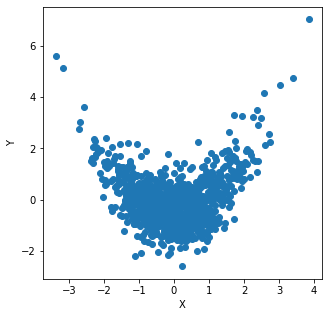

In [11]:

n = 1000
key, subkey = random.split(key)
d = 2
xs = random.normal(key, shape = (n,1))
ys = (xs**2)/2 + random.normal(subkey, shape = (n,1))/jnp.sqrt(2)
samps = jnp.concatenate([xs,ys], axis=1)

samps = (samps - jnp.average(samps, axis = 0))/jnp.std(samps, axis = 0)
plt.rcParams["figure.figsize"] = (5,5)
plt.scatter(samps[:,0], samps[:,1])
plt.xlabel("X")
plt.ylabel("Y")


In [12]:
params = [init_icnn_params(x_layer_widths = [1, 2, 2, 1], y_layer_widths=[1, 3, 3, 1], picnn=False)]
for i in jnp.arange(1,d):
    params.append(init_icnn_params(x_layer_widths = [i, (i+1), (i+1), 1], y_layer_widths=[1, 3,  3, 1], picnn=True))
z0 = jnp.zeros(shape = (d,))
print(flow_forward(params, z0), KL_loss(params, samps))

[0.6045175  0.03157037] 3.258588


In [13]:
adam = AdamOptim(eta=LEARNING_RATE, beta1=BETA1, beta2=BETA2, epsilon=EPSILON, params=params)
kl = jnp.array([KL_loss(params, samps)])
diff = 10
itr = 0
print("Iter: ", itr, "KL loss: ", kl[itr], "Non-monotonicity metric: ", 0)

while (diff > 1e-5):
    itr += 1
    grads = grad(KL_loss, argnums=0)(params, samps)
    params = adam.update(params, grads, t=itr)
    kl = jnp.hstack((kl, KL_loss(params, samps)))
    diff = jnp.abs((kl[-1] - kl[-2])/kl[-2])
    if(itr % 100 ==0):
        reg = 0
        for i in range(d):
            for layers in params[i]:
                reg += jnp.sum(layers['weights_z'][layers['weights_z'] < 0]**2)
        print("Iter: ", itr, "KL loss: ", kl[itr], "Non-monotonicity metric: ", reg)


Iter:  0 KL loss:  3.258588 Non-monotonicity metric:  0
Iter:  100 KL loss:  1.8010606 Non-monotonicity metric:  0.0
Iter:  200 KL loss:  1.7880687 Non-monotonicity metric:  2.817037e-09


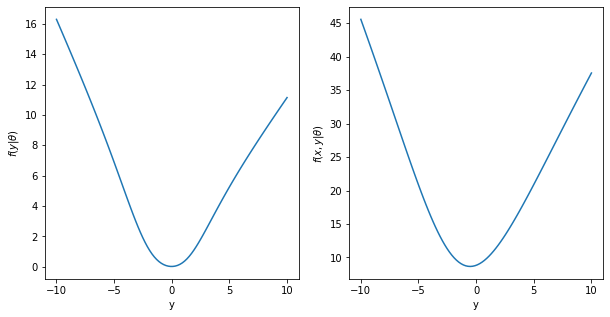

<Figure size 720x360 with 0 Axes>

In [14]:
xs = jnp.reshape(jnp.linspace(-10, 10, 100), (100,1))
ys = (vec_ficnn(params[0], xs))
plt.rcParams["figure.figsize"] = (10,5)
plt.subplot(1,d,1)
plt.plot(xs, ys)
plt.xlabel("y")
plt.ylabel(r"$f(y | \theta)$")
for i in jnp.arange(1,d):
    ys = (vec_picnn(params[i], z0[:i], xs))
    plt.subplot(1,d,(i+1).item())
    plt.plot(xs, ys)
    plt.xlabel("y")
    plt.ylabel(r"$f(x,y | \theta)$")
plt.show()
plt.savefig('banana/banana-monotonicity.png')

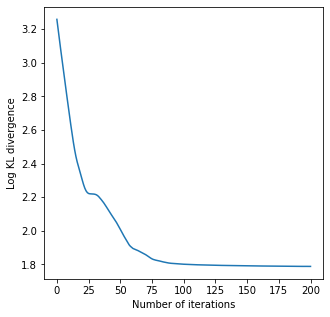

In [15]:
plt.rcParams["figure.figsize"] = (5,5)
plt.xlabel("Number of iterations")
plt.ylabel("Log KL divergence")
plt.plot(jnp.arange(0, jnp.size(kl)), kl)
plt.savefig('banana/banana-optim_curve.png')

In [16]:
z = vec_flow(params, samps)
jnp.std(z, axis = 0)

DeviceArray([0.57648396, 0.81750375], dtype=float32)

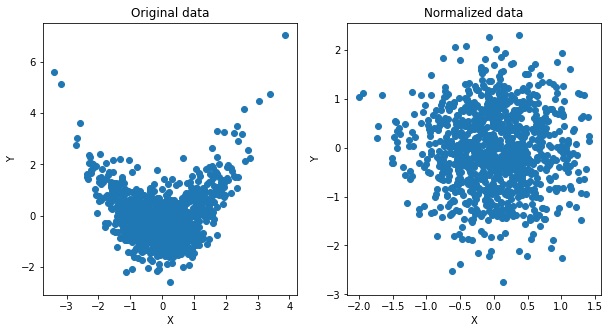

In [17]:
plt.rcParams["figure.figsize"] = (10,5)
plt.subplot(1,2,1)
plt.scatter(samps[:,0], samps[:,1])
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Original data")
plt.subplot(1,2,2)
plt.scatter(z[:,0],z[:,1])
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Normalized data")
plt.savefig('banana/banana-scatter.png')

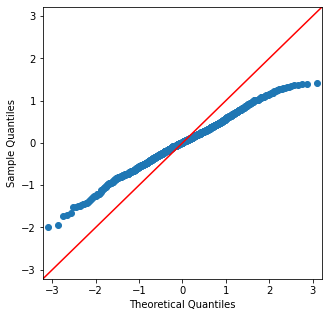

<Figure size 360x360 with 0 Axes>

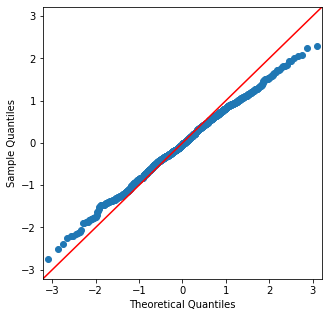

<Figure size 360x360 with 0 Axes>

In [18]:
plt.rcParams["figure.figsize"] = (5,5)
fig1 = sm.qqplot(z[:,0], line='45')
plt.show()
plt.savefig('banana/banana-qq1.png')
fig2 = sm.qqplot(z[:,1], line='45')
plt.show()
plt.savefig('banana/banana-qq2.png')

### Gaussian Mixture

Text(0, 0.5, 'Y')

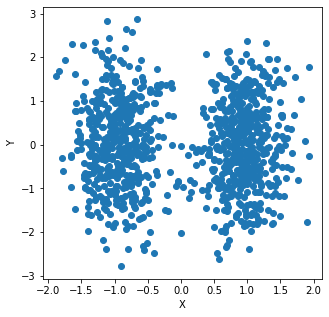

In [21]:

n = 1000
key, subkey = random.split(key)

#### Mixture of Gaussians

d = 2
xs = random.normal(key, shape = (n,1))
ys = random.normal(subkey, shape = (n,1))
xs = xs.at[:int(n/2)].set(xs[:int(n/2)] + 3)
xs = xs.at[int(n/2):].set(xs[int(n/2):] - 3)
samps = jnp.concatenate((xs, ys), axis = 1)

samps = (samps - jnp.average(samps, axis = 0))/jnp.std(samps, axis = 0)
plt.rcParams["figure.figsize"] = (5,5)
plt.scatter(samps[:,0], samps[:,1])
plt.xlabel("X")
plt.ylabel("Y")


In [22]:
params = [init_icnn_params(x_layer_widths = [1, 2, 2, 1], y_layer_widths=[1, 3, 3, 1], picnn=False)]
for i in jnp.arange(1,d):
    params.append(init_icnn_params(x_layer_widths = [i, (i+1), (i+1), 1], y_layer_widths=[1, 3,  3, 1], picnn=True))
z0 = jnp.zeros(shape = (d,))
print(flow_forward(params, z0), KL_loss(params, samps))

[-0.4854094   0.32593206] 4.002867


In [23]:
adam = AdamOptim(eta=LEARNING_RATE, beta1=BETA1, beta2=BETA2, epsilon=EPSILON, params=params)
kl = jnp.array([KL_loss(params, samps)])
diff = 10
itr = 0
print("Iter: ", itr, "KL loss: ", kl[itr], "Non-monotonicity metric: ", 0)
while (diff > 1e-5):
    itr += 1
    grads = grad(KL_loss, argnums=0)(params, samps)
    params = adam.update(params, grads, t=itr)
    kl = jnp.hstack((kl, KL_loss(params, samps)))
    diff = jnp.abs((kl[-1] - kl[-2])/kl[-2])
    if(itr % 100 ==0):
        reg = 0
        for i in range(d):
            for layers in params[i]:
                reg += jnp.sum(layers['weights_z'][layers['weights_z'] < 0]**2)
        print("Iter: ", itr, "KL loss: ", kl[itr], "Non-monotonicity metric: ", reg)

        

Iter:  0 KL loss:  4.002867 Non-monotonicity metric:  0
Iter:  100 KL loss:  1.869989 Non-monotonicity metric:  0.0
Iter:  200 KL loss:  1.6263412 Non-monotonicity metric:  0.0
Iter:  300 KL loss:  1.579369 Non-monotonicity metric:  0.0
Iter:  400 KL loss:  1.5191683 Non-monotonicity metric:  0.0
Iter:  500 KL loss:  1.4432888 Non-monotonicity metric:  0.0
Iter:  600 KL loss:  1.340719 Non-monotonicity metric:  0.0
Iter:  700 KL loss:  1.2343999 Non-monotonicity metric:  0.0
Iter:  800 KL loss:  1.2050139 Non-monotonicity metric:  1.2947133e-08
Iter:  900 KL loss:  1.1926492 Non-monotonicity metric:  4.602255e-09
Iter:  1000 KL loss:  1.1843196 Non-monotonicity metric:  0.0


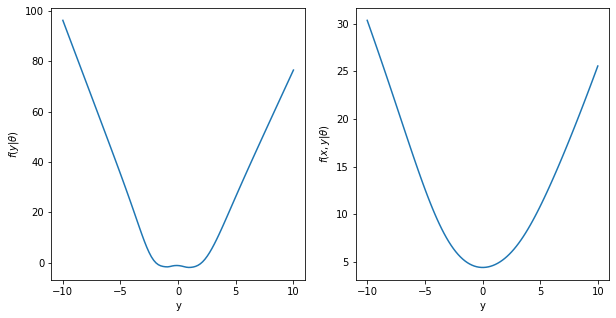

<Figure size 720x360 with 0 Axes>

In [24]:
xs = jnp.reshape(jnp.linspace(-10, 10, 100), (100,1))
ys = (vec_ficnn(params[0], xs))
plt.rcParams["figure.figsize"] = (10,5)
plt.subplot(1,d,1)
plt.plot(xs, ys)
plt.xlabel("y")
plt.ylabel(r"$f(y | \theta)$")
for i in jnp.arange(1,d):
    ys = (vec_picnn(params[i], z0[:i], xs))
    plt.subplot(1,d,(i+1).item())
    plt.plot(xs, ys)
    plt.xlabel("y")
    plt.ylabel(r"$f(x,y | \theta)$")
plt.show()
plt.savefig('gaussian_mixture/gm-monotonicity.png')

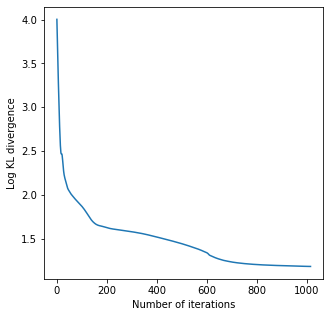

In [25]:
plt.rcParams["figure.figsize"] = (5,5)
plt.xlabel("Number of iterations")
plt.ylabel("Log KL divergence")
plt.plot(jnp.arange(0, jnp.size(kl)), kl)
plt.savefig('gaussian_mixture/gm-optim_curve.png')

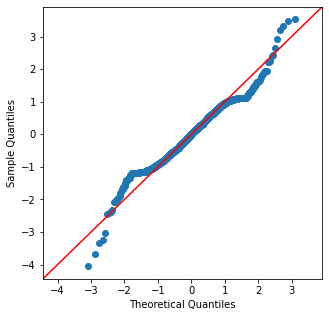

<Figure size 360x360 with 0 Axes>

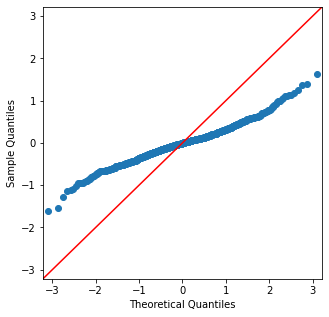

<Figure size 360x360 with 0 Axes>

In [26]:
z = vec_flow(params, samps)
jnp.std(z, axis = 0)
plt.rcParams["figure.figsize"] = (5,5)
fig1 = sm.qqplot(z[:,0], line='45')
plt.show()
plt.savefig('gaussian_mixture/gm-qq1.png')
fig2 = sm.qqplot(z[:,1], line='45')
plt.show()
plt.savefig('gaussian_mixture/gm-qq2.png')

### Spiral Distribution


Text(0, 0.5, 'Y')

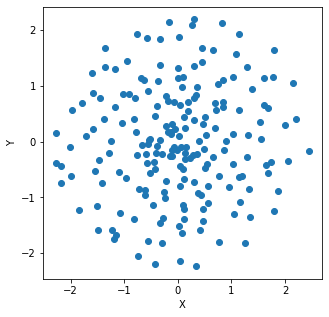

In [28]:

d=2
samps = np.loadtxt("spiral/spiral.data")
samps = samps[:,:2]
samps = samps + 0.05*random.normal(key, shape = samps.shape)
n = samps.shape[0]
samps = (samps - jnp.average(samps, axis = 0))/jnp.std(samps, axis = 0)
plt.rcParams["figure.figsize"] = (5,5)
plt.scatter(samps[:,0], samps[:,1])
plt.xlabel("X")
plt.ylabel("Y")


In [29]:
params = [init_icnn_params(x_layer_widths = [1, 2, 2, 1], y_layer_widths=[1, 3, 3, 1], picnn=False)]
for i in jnp.arange(1,d):
    params.append(init_icnn_params(x_layer_widths = [i, (i+1), (i+1), 1], y_layer_widths=[1, 3,  3, 1], picnn=True))
z0 = jnp.zeros(shape = (d,))
print(flow_forward(params, z0), KL_loss(params, samps))

[-0.4854094   0.32593206] 4.0222683


In [30]:
adam = AdamOptim(eta=LEARNING_RATE, beta1=BETA1, beta2=BETA2, epsilon=EPSILON, params=params)
kl = jnp.array([KL_loss(params, samps)])
diff = 10
itr = 0
print("Iter: ", itr, "KL loss: ", kl[itr], "Non-monotonicity metric: ", 0)
while (diff > 1e-5):
    itr += 1
    grads = grad(KL_loss, argnums=0)(params, samps)
    params = adam.update(params, grads, t=itr)
    kl = jnp.hstack((kl, KL_loss(params, samps)))
    diff = jnp.abs((kl[-1] - kl[-2])/kl[-2])
    if(itr % 100 ==0):
        reg = 0
        for i in range(d):
            for layers in params[i]:
                reg += jnp.sum(layers['weights_z'][layers['weights_z'] < 0]**2)
        print("Iter: ", itr, "KL loss: ", kl[itr], "Non-monotonicity metric: ", reg)

        

Iter:  0 KL loss:  4.0222683 Non-monotonicity metric:  0
Iter:  100 KL loss:  2.0081186 Non-monotonicity metric:  0.0
Iter:  200 KL loss:  1.9749951 Non-monotonicity metric:  0.0
Iter:  300 KL loss:  1.9635217 Non-monotonicity metric:  0.0
Iter:  400 KL loss:  1.9491367 Non-monotonicity metric:  0.0
Iter:  500 KL loss:  1.9304867 Non-monotonicity metric:  0.0
Iter:  600 KL loss:  1.9236552 Non-monotonicity metric:  1.3589299e-07


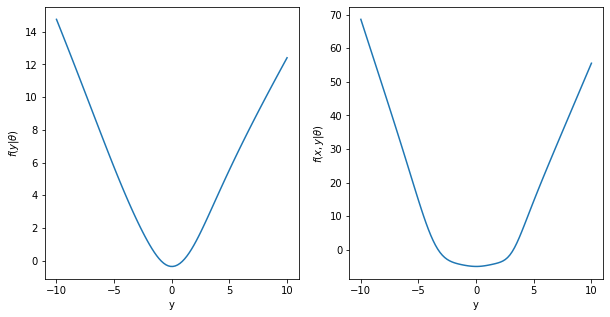

<Figure size 720x360 with 0 Axes>

In [31]:
xs = jnp.reshape(jnp.linspace(-10, 10, 100), (100,1))
ys = (vec_ficnn(params[0], xs))
plt.rcParams["figure.figsize"] = (10,5)
plt.subplot(1,d,1)
plt.plot(xs, ys)
plt.xlabel("y")
plt.ylabel(r"$f(y | \theta)$")
for i in jnp.arange(1,d):
    ys = (vec_picnn(params[i], z0[:i], xs))
    plt.subplot(1,d,(i+1).item())
    plt.plot(xs, ys)
    plt.xlabel("y")
    plt.ylabel(r"$f(x,y | \theta)$")
plt.show()
plt.savefig('spiral/spiral-monotonicity.png')

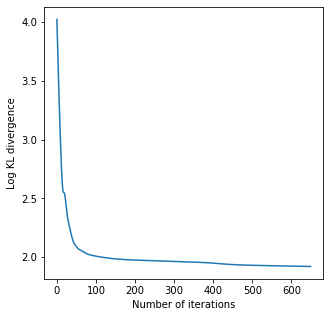

In [32]:
plt.rcParams["figure.figsize"] = (5,5)
plt.xlabel("Number of iterations")
plt.ylabel("Log KL divergence")
plt.plot(jnp.arange(0, jnp.size(kl)), kl)
plt.savefig('spiral/spiral-optim_curve.png')

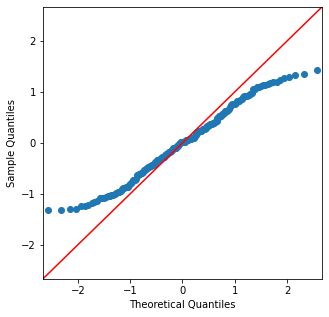

<Figure size 360x360 with 0 Axes>

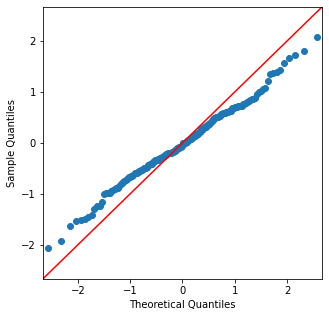

<Figure size 360x360 with 0 Axes>

In [33]:
z = vec_flow(params, samps)
jnp.std(z, axis = 0)
plt.rcParams["figure.figsize"] = (5,5)
fig1 = sm.qqplot(z[:,0], line='45')
plt.show()
plt.savefig('spiral/spiral-qq1.png')
fig2 = sm.qqplot(z[:,1], line='45')
plt.show()
plt.savefig('spiral/spiral-qq2.png')

In [ ]:
git init -b main